# Data Management Project: Bitcoin sentiment analysis

## Data sources:
- YFinance library
- NyTimes news: API endpoint -> https://api.nytimes.com/svc/search/v2/articlesearch.json?q=election&api-key=yourkey

(Limit NYtimes: Yes, there are two rate limits per API: 500 requests per day and 5 requests per minute. You should sleep 12 seconds between calls to avoid hitting the per minute rate limit. If you need a higher rate limit, please contact us at code@nytimes.com.)

Important: 
- create in your environment a .env file
- write: NY_KEY = "your_key"
- use the command load_dotenv()
- key = os.getenv("NY_KEY")

In [1]:
# utility libraries
import os
import json
import time
from tqdm import tqdm
from bson.json_util import dumps
from bson.json_util import loads

# data preprocessing libraries
import numpy as np
import pandas as pd

# time series utility libraries
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

# api utility library
import requests

# key management library
from dotenv import load_dotenv

# plot library
import matplotlib.pyplot as plt

# kafka libraries
from kafka import KafkaProducer
from kafka import KafkaConsumer

# Mongodb library
from pymongo import MongoClient

# YFinance library
import yfinance as yf

load_dotenv()

True

## Prices:

We want to store prices from 2018-01-01 to 2025-12-12 for Bitcoin and Ethereum, two important cryptovalues.

In [12]:
df = yf.download(["BTC-USD","ETH-USD"], start="2018-01-01", end="2025-12-12")
df.head()

C:\Users\tomma\AppData\Local\Temp\ipykernel_30416\419930183.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(["BTC-USD","ETH-USD"], start="2018-01-01", end="2025-12-12")
[*********************100%***********************]  2 of 2 completed


Price              Close                      High                        Low  \
Ticker           BTC-USD     ETH-USD       BTC-USD      ETH-USD       BTC-USD   
Date                                                                            
2018-01-01  13657.200195  772.640991  14112.200195   782.530029  13154.700195   
2018-01-02  14982.099609  884.443970  15444.599609   914.830017  13163.599609   
2018-01-03  15201.000000  962.719971  15572.799805   974.471008  14844.500000   
2018-01-04  15599.200195  980.921997  15739.700195  1045.079956  14522.200195   
2018-01-05  17429.500000  997.719971  17705.199219  1075.390015  15202.799805   

Price                           Open                   Volume              
Ticker         ETH-USD       BTC-USD     ETH-USD      BTC-USD     ETH-USD  
Date                                                                       
2018-01-01  742.004028  14112.200195  755.757019  10291200000  2595760128  
2018-01-02  772.346008  13625.000000  772.346008  16846600192  5783349760  
2018-01-03  868.450989  14978.200195  886.000000  16871900160  5093159936  
2018-01-04  946.085999  15270.700195  961.713013  21783199744  6502859776  
2018-01-05  956.325012  15477.200195  975.750000  23840899072  6683149824

In [13]:
df.isna().sum() # There is no Missing Values

Price   Ticker 
Close   BTC-USD    0
        ETH-USD    0
High    BTC-USD    0
        ETH-USD    0
Low     BTC-USD    0
        ETH-USD    0
Open    BTC-USD    0
        ETH-USD    0
Volume  BTC-USD    0
        ETH-USD    0
dtype: int64

In [7]:
df_stacked = df.stack(level=1, future_stack=True)
# reset index 
df_final = df_stacked.reset_index()


# ('Date' -> 'date', 'Ticker' -> 'ticker', 'Adj Close' -> 'adj_close')
df_final.columns = [c.lower().replace(' ', '_') for c in df_final.columns]

# date to native date-format
df_final['date'] = pd.to_datetime(df_final['date'])

# --- 3. EXTRA Cleaning ---
# NaN --> None (beacause of the MongoDB logic)
df_final = df_final.where(pd.notnull(df_final), None)

# Dataframe to List of Dict
records = df_final.to_dict(orient='records')

print(f"Ready to insert {len(records)} record.")

# --- 4. MONGODB INSERT ---
client = MongoClient("mongodb://localhost:27017")
db = client['DM_DB']
collection = db['Crypto']

try:
    if records:
        
        result = collection.insert_many(records)
        print(f"{len(result.inserted_ids)} document in 'CryptoPrices'.")
    else:
        print("Nothing to insert.")

except Exception as e:
    print(f"Error during the insertion: {e}")

# --- Control ---
print("\nVerifying the last btc")
latest = collection.find_one({"ticker": "BTC-USD"}, sort=[("date", -1)])
print(latest)

Ready to insert 5804 record.
5804 document in 'CryptoPrices'.

Verifying the last btc
{'_id': ObjectId('6945798fd65f26c5a42ef2d5'), 'date': datetime.datetime(2025, 12, 11, 0, 0), 'ticker': 'BTC-USD', 'close': 92511.3359375, 'high': 93554.265625, 'low': 89335.296875, 'open': 92011.3046875, 'volume': 64532834621}


### Some Visualization

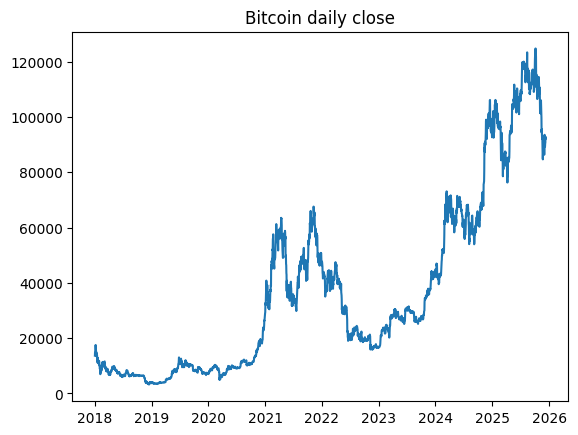

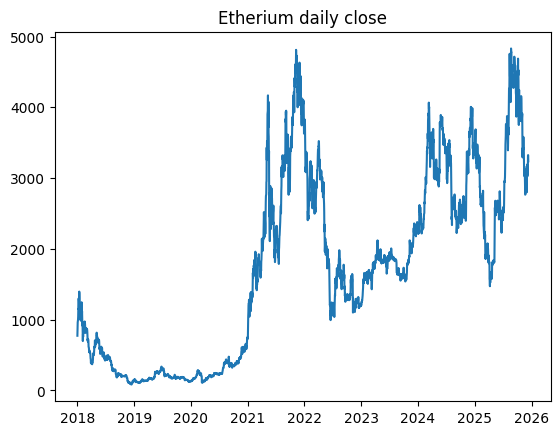

In [14]:
plt.figure()
plt.plot(df.index,df['Close']['BTC-USD'])
plt.title("Bitcoin daily close")
plt.show()
plt.figure()
plt.plot(df.index,df['Close']['ETH-USD'])
plt.title("Etherium daily close")
plt.show()

## NyTimes article:

1. **Data retrieval from the New York Times API**  
   - Uses the API key stored in the environment variable `NY_KEY`.  
   - Searches for the queries `"Bitcoin"` and `"Crypto"`.  
   - Iterates through 100 pages of results for each query.

2. **Request and error handling**  
   - Each HTTP request is executed using `requests.get`.  
   - The response status is checked with `raise_for_status()` to catch any HTTP errors.  
   - In case of an error (e.g., `429 Too Many Requests`, timeout, connection issues), the error is logged and the loop continues with the next request.

3. **Sending data to Kafka**  
   - If the response is valid, the JSON data is sent to a Kafka topic corresponding to the query (`Bitcoin` or `Crypto`).  
   - This allows real-time processing or storage of the data via a Kafka consumer.

4. **Rate limit management**  
   - After each request, the script waits 15 seconds (`time.sleep(15)`) to avoid exceeding NYT API limits, reducing the risk of `429 Too Many Requests` errors.

**Note:** The script is designed to safely scrape data while respecting the NYT API's per-minute and daily limits, sending the collected data to Kafka for further processing.


We want to use a `Kafka producer and consumer` to store NyTimes Articles into the DB, thus because of the risk to lost data during the api request procedure.

In [ ]:
# Cella da cancellare (per ora la tengo)
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],
    value_serializer=lambda x: json.dumps(x).encode('utf-8')
)

# Imposta il periodo storico
start_date = date(2022, 10, 1)
end_date = date(2025, 12, 12)
current_date = start_date

DAILY_LIMIT = 490
calls_made = 0

key = os.getenv("NY_KEY2")
queries = ["Bitcoin", "Crypto", "Ethereum"]

while current_date < end_date:
    next_month = current_date + relativedelta(months=1)
    
    # Formatta le date per l'API NYT (YYYYMMDD)
    begin_str = current_date.strftime("%Y%m%d")
    end_str = next_month.strftime("%Y%m%d")
    
    print(f"\n--- Analisi periodo: {begin_str} - {end_str} ---")
    
    # MODIFICA 1: Iteriamo prima per Query, poi per Pagine.
    # Questo ci permette di interrompere la paginazione per una query specifica appena finiscono i dati.
    for q in queries:
        print(f"Scaricando articoli per: {q}...")
        
        for page in range(100): # Massimo 100 pagine
            if calls_made >= DAILY_LIMIT:
                print(f"RAGGIUNTO IL LIMITE GIORNALIERO ({calls_made}). Mi fermo.")
                print(f"Ultimo periodo elaborato: {begin_str} - {end_str}, Query: {q}, Pagina: {page}")
                exit()
            try:
                # MODIFICA 2: Corretto q={q} nell'URL (prima era fisso su Bitcoin)
                url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?q={q}&begin_date={begin_str}&end_date={end_str}&page={page}&api-key={key}"
                
                response = requests.get(url)
                response.raise_for_status() # Solleva errore se status != 200

                data = response.json()
                articles = data.get('response', {}).get('docs', [])

                # MODIFICA 3: Se non ci sono articoli, interrompiamo il ciclo delle pagine per QUESTA query
                if not articles:
                    print(f"  -> Nessun altro articolo per '{q}' a pagina {page}. Passo alla prossima query.")
                    break 

                # Invio messaggi a Kafka
                for article in articles:
                    clean_doc = {
                        'remote_id': article.get('_id'),
                        'web_url': article.get('web_url'),
                        'pub_date': article.get('pub_date'),
                        'abstract': article.get('abstract'),
                        'lead_paragraph': article.get('lead_paragraph'),
                        'title': article.get('headline', {}).get('main'),
                        'word_count': article.get('word_count'),
                        'source_query': q
                    }
                    
                    producer.send(q, clean_doc) # Usa 'q' come nome del topic (o usa un topic unico)
            
                producer.flush()
                print(f"  -> Inviati {len(articles)} articoli per '{q}' (Pagina {page})")
                
                # Rispetta il rate limit (15 secondi sono prudenziali e sicuri)
                time.sleep(15)
                calls_made += 1

            except Exception as e:
                print(f"  -> Errore con '{q}' a pagina {page}: {e}")
                # Opzionale: se l'errore è grave (es. 429 Too Many Requests), potresti voler fare un break anche qui
                # break 
                time.sleep(15) # Attesa anche in caso di errore per sicurezza
                continue

    # Passa al mese successivo solo dopo aver finito tutte le query per il mese corrente
    current_date = next_month

In [ ]:
# ---------------------------------------------------------
# User Configuration
# ---------------------------------------------------------


start_date = date(2018, 1, 1) # Set Start and End Date
end_date = date(2025, 12, 12)

# ---------------------------------------------------------
# ---------------------------------------------------------

# Setup Kafka
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],
    value_serializer=lambda x: json.dumps(x).encode('utf-8')
)

DAILY_LIMIT = 480 # We choose a daily-limit request of 480 istead of 500 (the actual NyTimes limit) to have some debug-call.
calls_made = 0 # counter

key = os.getenv("NY_KEY") # get the api key
queries = ["Bitcoin", "Crypto", "Ethereum"] # Choosen queries
current_date = start_date

print(f"Script Start from: {start_date}")

while current_date < end_date:
    next_month = current_date + relativedelta(months=1)
    
    begin_str = current_date.strftime("%Y%m%d")
    end_str = next_month.strftime("%Y%m%d")
    
    print(f"Month: {begin_str} - {end_str} ---")
    
    for q in queries:
        print(f"{q}...")
        
        # Cycle for every page ffrom 0 to 100
        for page in range(100): 
            
            # --- Daily-limit control ---
            if calls_made >= DAILY_LIMIT:
                print(f"STOP: daily requests limit reached ({calls_made}).")
                print(f"Restart from: {begin_str}, Query: {q}, Page: {page}")
                exit() # Close the Program

            # ------
            attempt_success = False
            should_stop_pages = False

            while not attempt_success:
                try:
                    # endpoint
                    url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?q={q}&begin_date={begin_str}&end_date={end_str}&page={page}&api-key={key}"
                    
                    response = requests.get(url)
                    
                    # CASe 1: ERROR 429 (too much requests, one each 12 second)
                    if response.status_code == 429:
                        print(f"Error (429). waiting for 70 second e re-try the page: {page}...")
                        time.sleep(70) 
                        continue 
                    
                    # Control for other error
                    response.raise_for_status()

                    data = response.json()
                    articles = data.get('response', {}).get('docs', [])

                    # CASE 2: Empty Articles --> go tu the next query
                    if not articles:
                        print(f"No article found at page {page}.")
                        attempt_success = True 
                        should_stop_pages = True
                        break 

                    # CASE 3: Everything OK -> SEND TO KAFKA
                    for article in articles:
                        clean_doc = {
                            'remote_id': article.get('_id'),
                            'web_url': article.get('web_url'),
                            'pub_date': article.get('pub_date'),
                            'abstract': article.get('abstract'),
                            'lead_paragraph': article.get('lead_paragraph'),
                            'title': article.get('headline', {}).get('main'),
                            'word_count': article.get('word_count'),
                            'source_query': q
                        }
                        producer.send(q, clean_doc)
            
                    producer.flush()
                    print(f"Found {len(articles)} articles (Page {page})")
                    
                    calls_made += 1
                    attempt_success = True 
                    
                    
                    time.sleep(12) 

                except Exception as e:
                    # CASE 4: Generic Error
                    print(f"Generic Error: {e}")
                    print("Try after 15 seconds")
                    time.sleep(15)
                    

            if should_stop_pages:
                break 

    current_date = next_month

1. **Kafka Consumers Setup**  
   - Two separate consumers are created:
     - `consumer_bitcoin` subscribes to the `"Bitcoin"` topic.
     - `consumer_crypto` subscribes to the `"Crypto"` topic.
   - Both consumers:
     - Connect to the Kafka broker at `localhost:9092`.
     - Deserialize messages from JSON using `json.loads`.
     - Start reading from the earliest available message (`auto_offset_reset="earliest"`) to process past messages.
     - Use a new consumer group `"debug-group"` to avoid committing offsets from previous runs.

2. **MongoDB Setup**  
   - Connects to a local MongoDB instance (`mongodb://localhost:27017`).
   - Uses the database `bitcoin_pr`.
   - Stores articles in the collection `Article`.

3. **Message Consumption and Storage**  
   - For each message received from the `"Bitcoin"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Bitcoin"`.
     - Inserts the document into the MongoDB collection.
   - For each message received from the `"Crypto"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Crypto"`.
     - Inserts the document into MongoDB.

4. **Notes**
   - Using `auto_offset_reset="earliest"` allows the consumer to read **all previous messages** in the topic, which is useful for debugging or reprocessing data.
   - Each consumer runs in a blocking loop, continuously waiting for new messages.
   - Ensure MongoDB is running locally before executing the script.



In [ ]:
consumer_bitcoin = KafkaConsumer(
    "Bitcoin",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",  
    enable_auto_commit=True,
    group_id="debug-group",         
    consumer_timeout_ms=10000
)

consumer_crypto = KafkaConsumer(
    "Crypto",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   
    enable_auto_commit=True,
    group_id="debug-group-crypto",        
    consumer_timeout_ms=10000
)

consumer_eth = KafkaConsumer(
    "Ethereum",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   
    enable_auto_commit=True,
    group_id="debug-group-eth",         
    consumer_timeout_ms=10000
)



In [ ]:
client = MongoClient("mongodb://localhost:27017")

db = client['DM_DB']

collection = db['Article']

print("Waiting for Ethereum messages...")
for msg in consumer_eth:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Ethereum'
    collection.insert_one(doc)

print("Waiting for Bitcoin messages...")
for msg in consumer_bitcoin:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Bitcoin'
    collection.insert_one(doc)

print("Waiting for Crypto messages...")
for msg in consumer_crypto:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Crypto'
    collection.insert_one(doc)

print("All messages consumed.")


In [ ]:
client = MongoClient("mongodb://localhost:27017")

db = client['DM_DB']

collection = db['Articles']


#### This cells are useful to load the json data downloaded from the api calls

In [ ]:
#SAVE The Data in a Json file
output_filename = 'completo.json'

print(f"Start Import of {output_filename} ---")

cursor = collection.find({}) 

articles_list = list(cursor)

if len(articles_list) > 0:
    
    try:
        with open(output_filename, 'w', encoding='utf-8') as f:
        
            f.write(dumps(articles_list, indent=4, ensure_ascii=False))
            
        print(f"Saved {len(articles_list)} articles in '{output_filename}'.")
        print(f"Path: {os.path.abspath(output_filename)}")
        
    except Exception as e:
        print(f"Error: {e}")
else:
    print("Empty Articles")



--- Inizio esportazione su file JSON: completo.json ---
✅ Successo! Salvati 2902 articoli nel file 'completo.json'.
   Percorso file: c:\Users\tomma\Desktop\magistrale\DataMan-Project\completo.json
Fine procedura.


In [46]:

input_filename = 'articoli_nyt_completofin.json' # Change with the name of the file
db_name = 'DM_DB' # Choose a DB name
collection_name = 'Article'

# Connect to DB
client = MongoClient("mongodb://localhost:27017")
db = client[db_name]
collection = db[collection_name]

print(f"Start Import {input_filename} to MongoDB ({collection_name}) ---")

# 1. Does the file exist?
if not os.path.exists(input_filename):
    print(f"Error: file '{input_filename}' doesn't exist.")
    exit()

try:
    # 2. Json 
    with open(input_filename, 'r', encoding='utf-8') as f:
        
        data = loads(f.read())

    if isinstance(data, list) and len(data) > 0:
       
        # 3. Insert into MongoDB (Bulk Insert)
        result = collection.insert_many(data, ordered=False)
        print(f"Complete insertion, {len(result.inserted_ids)} documents.")
        

    else:
        print("empty json")

except Exception as e:
    print(f"Error: {e}")


Start Import articoli_nyt_completofin.json to MongoDB (Article) ---
Complete insertion, 914 documents.


### Duplicate

In [47]:
pipeline = [

    {

        "$group": {

            "_id": "$remote_id",  

            "count": {"$sum": 1},

            "docs": {"$push": "$_id"}

        }

    },

    {

        "$match": {

            "count": {"$gt": 1}

        }

    }

]



duplicati = list(collection.aggregate(pipeline))



print(f"Found {len(duplicati)} duplicated.")



for d in duplicati[:5]:

    print(f"Same URL {d['_id']} in {d['count']} Articles.")



Found 2010 duplicated.
Same URL nyt://article/ab63c707-2349-5452-927a-27fb129d531a in 2 Articles.
Same URL nyt://article/5e335356-9bad-50bf-90c2-3b30eb68e3e5 in 2 Articles.
Same URL nyt://article/b71656fe-d474-555d-9f03-2685f41b055e in 2 Articles.
Same URL nyt://article/83d96d44-831d-5070-8a9f-d36c872bde24 in 2 Articles.
Same URL nyt://article/621f84d7-5e6c-5a34-a61c-43fbb2d046b4 in 2 Articles.


In [48]:
num_articles = collection.count_documents({})
print(f"Number of articles in the collection: {num_articles}")

num_bitcoin = collection.count_documents({'source_query': 'Bitcoin'})
num_crypto = collection.count_documents({'source_query': 'Crypto'})
num_eth = collection.count_documents({'source_query': 'Ethereum'})


print(f"Number of Bitcoin articles: {num_bitcoin}")
print(f"Number of Crypto articles: {num_crypto}")
print(f"Number of Ethereum articles: {num_eth}")




Number of articles in the collection: 7257
Number of Bitcoin articles: 2458
Number of Crypto articles: 4172
Number of Ethereum articles: 627


In [50]:
#Duplication Rate:
len(duplicati)/num_articles*100

27.69739561802398

Deduplication:

In [51]:
# DEDUPLICATION:



duplicati = list(collection.aggregate(pipeline))

print(f"Found {len(duplicati)} duplicated URL.")





ids_da_cancellare = []



for d in duplicati:

    ids_da_cancellare.extend(d['docs'][1:])



if ids_da_cancellare:

    print(f"Deleting {len(ids_da_cancellare)} duplicated Articles...")

   

    risultato = collection.delete_many({"_id": {"$in": ids_da_cancellare}})

   

else:

    print("No Duplicated Articles.")



Found 2010 duplicated URL.
Deleting 3592 duplicated Articles...


In [53]:
pipeline = [

    {

        "$group": {

            "_id": "$remote_id",  

            "count": {"$sum": 1},

            "docs": {"$push": "$_id"}

        }

    },

    {

        "$match": {

            "count": {"$gt": 1}

        }

    }

]



duplicati = list(collection.aggregate(pipeline))



print(f"Found {len(duplicati)} duplicated.")



for d in duplicati[:5]:

    print(f"Same URL {d['_id']} in {d['count']} Articles.")



Found 0 duplicated.


In [52]:
num_articles = collection.count_documents({})
print(f"Number of articles in the collection: {num_articles}")

num_bitcoin = collection.count_documents({'source_query': 'Bitcoin'})
num_crypto = collection.count_documents({'source_query': 'Crypto'})
num_eth = collection.count_documents({'source_query': 'Ethereum'})


print(f"Number of Bitcoin articles: {num_bitcoin}")
print(f"Number of Crypto articles: {num_crypto}")
print(f"Number of Ethereum articles: {num_eth}")




Number of articles in the collection: 3665
Number of Bitcoin articles: 1259
Number of Crypto articles: 2280
Number of Ethereum articles: 126


# Integration:


## For Each Day with context (Latest Version):

In [54]:
# 1. SETUP
client = MongoClient("mongodb://localhost:27017/")
db_source = client["DM_DB"]
db_dest = client["DM_DB_Integrated"] # DB Destination

print("Loading data...")
articles_data = list(db_source["Article"].find({}))
prices_data = list(db_source["Crypto"].find({}))

df_articles = pd.DataFrame(articles_data)
df_prices = pd.DataFrame(prices_data)

# --- Phase 1: Prices Preparation ---
rename_map = {
    'Ticker': 'asset', 'ticker': 'asset', 'Symbol': 'asset',
    'Date': 'date', 'Close': 'close', 'Open': 'open'
}
df_prices.rename(columns=rename_map, inplace=True)

# Normalizing Date ---> Jet lag
df_prices['date'] = pd.to_datetime(df_prices['date'], utc=True).dt.normalize()
df_prices = df_prices.sort_values(by=['asset', 'date'])
df_prices = df_prices.drop_duplicates(subset=['asset', 'date'], keep='last')

# List of Asset
all_assets = ['BTC-USD', 'ETH-USD']
print(f"Asset: {all_assets}")

price_map = {}
for record in df_prices.to_dict('records'):
    key = (record['asset'], record['date'])
    price_map[key] = {'open': record.get('open'), 'close': record.get('close')}

# --- Phase 2: Articles Preparation (Group by) ---
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'], utc=True).dt.normalize()

print("Group by day...")
articles_by_day = {}

for record in df_articles.to_dict('records'):
    d_date = record['pub_date']
    
    article_clean = {
        "remote_id": record.get('remote_id'),
        "title": record.get('title') if record.get('title') else record.get('headline', {}).get('main'),
        "url": record.get('web_url'),
        "source_query": record.get('source_query'),
        "abstract": record.get('abstract')
    }
    
    if d_date not in articles_by_day:
        articles_by_day[d_date] = []
    articles_by_day[d_date].append(article_clean)

# --- Phase 3: Daily Articles---

unique_dates = sorted(df_prices['date'].unique())

final_docs = []
print(f"Creazione documenti per {len(unique_dates)} giorni...")

for current_date in unique_dates:
    
    # 1. Daily articles acquisition
    daily_articles = articles_by_day.get(current_date, [])
    
    # 2. document structure
    doc = {
        "date": current_date,
        "date_str": current_date.strftime('%Y-%m-%d'), 
        "articles": daily_articles, 
        "article_count": len(daily_articles),
        "prices": {} 
    }
    
    # 3. Asset Metrics
    has_price_data = False 
    
    for asset in all_assets:
        
        def get_p(delta_days):
            target = current_date + timedelta(days=delta_days)
            return price_map.get((asset, target))

        t0 = get_p(0)       # Today
        t_m1 = get_p(-1)    # Yesterday
        t_p1 = get_p(1)     # Tomorrow
        t_m7 = get_p(-7)    # Last Week
        t_p7 = get_p(7)     # Next Week
        
        if not t0:
            continue
            
        has_price_data = True
        
        open_t0 = t0['open']
        close_t0 = t0['close']
        
        asset_data = {
            "open": open_t0,
            "close": close_t0,
            "intraday_change": close_t0 - open_t0 if open_t0 else None,
            "context": {
                "close_prev_day": t_m1['close'] if t_m1 else None,
                "close_next_day": t_p1['close'] if t_p1 else None,
                "close_prev_week": t_m7['close'] if t_m7 else None,
                "close_next_week": t_p7['close'] if t_p7 else None
            },
            "future_trend": {
                "next_day_diff": t_p1['close'] - close_t0 if t_p1 else None,
                "next_week_diff": t_p7['close'] - close_t0 if t_p7 else None
            }
        }
        
        doc["prices"][asset] = asset_data

    if has_price_data or daily_articles:
        final_docs.append(doc)

# --- FASE 4: Saving ---
if final_docs:
    print(f"Saving {len(final_docs)} documents...")
    db_dest["daily_market_summary"].drop()
    db_dest["daily_market_summary"].insert_many(final_docs)
    
    print("\n--- Example ---")
    print(json.dumps(final_docs[0], indent=2, default=str))
else:
    print("Error.")

Loading data...
Asset: ['BTC-USD', 'ETH-USD']
Group by day...
Creazione documenti per 2902 giorni...
Saving 2902 documents...

--- Example ---
{
  "date": "2018-01-01 00:00:00+00:00",
  "date_str": "2018-01-01",
  "articles": [
    {
      "remote_id": "nyt://article/0b5cb41e-108e-5f19-95a4-fd821214f37f",
      "title": "Can the Economy Keep Calm and Carry On?",
      "url": "https://www.nytimes.com/2018/01/01/opinion/can-the-economy-keep-calm-and-carry-on.html",
      "source_query": "Bitcoin",
      "abstract": "Normally, presidents don\u2019t matter much. But our normality is fragile."
    }
  ],
  "article_count": 1,
  "prices": {
    "BTC-USD": {
      "open": 14112.2001953125,
      "close": 13657.2001953125,
      "intraday_change": -455.0,
      "context": {
        "close_prev_day": null,
        "close_next_day": 14982.099609375,
        "close_prev_week": null,
        "close_next_week": 15170.099609375
      },
      "future_trend": {
        "next_day_diff": 1324.899414062

### Data Quality:

In [ ]:

# --- 0. Connection ---
client = MongoClient("mongodb://localhost:27017/")
db = client["DM_DB_Integrated"]  # Using single DB reference since Source and Dest are the same

# Fetch all documents from the daily summary collection
# We convert to a list immediately so we can reuse the data without re-querying
print("--- LOADING DATA FOR DQ ---")
cursor = db["daily_market_summary"].find({})
all_daily_docs = list(cursor)

if not all_daily_docs:
    print("No documents found in 'daily_market_summary'. Check your database connection.")
    exit()

# 1. Load & Flatten RAW data (for metrics A and B)
# We need to extract nested data and "inject" the parent date into the child records

articles_flat_list = []
prices_flat_list = []

for doc in all_daily_docs:
    # Get the date from the parent document (e.g., "2018-01-24")
    # We fallback to None if missing, though it should exist based on schema
    doc_date = doc.get('date_str') 

    # --- Flatten Articles ---
    if 'articles' in doc and isinstance(doc['articles'], list):
        for article in doc['articles']:
            # Create a shallow copy to avoid modifying the original dict
            art_entry = article.copy()
            # Inject the date so we can check duplicates/timeliness later
            art_entry['date'] = doc_date 
            articles_flat_list.append(art_entry)

    # --- Flatten Prices ---
    if 'prices' in doc and isinstance(doc['prices'], dict):
        for ticker, price_data in doc['prices'].items():
            # price_data is { 'open': ..., 'close': ... }
            price_entry = price_data.copy()
            # Explicitly set the asset name and date
            price_entry['asset'] = ticker
            price_entry['date'] = doc_date
            prices_flat_list.append(price_entry)

# Create DataFrames from the flattened lists
df_articles = pd.DataFrame(articles_flat_list)
df_prices = pd.DataFrame(prices_flat_list)

print(f"Data Loaded:")
print(f"- Extracted Articles: {len(df_articles)}")
print(f"- Extracted Price Records: {len(df_prices)}")


# 2. Minimal Cleaning & Standardization

# --- Clean Prices ---
if not df_prices.empty:
    # Ensure date is datetime object
    df_prices['date'] = pd.to_datetime(df_prices['date'], utc=True).dt.normalize()
    
    # Sort for safety
    df_prices.sort_values(by=['asset', 'date'], inplace=True)
    
    # Get list of unique assets found
    all_assets = df_prices['asset'].unique().tolist()
else:
    all_assets = []

# --- Clean Articles ---
if not df_articles.empty:
    # Ensure date is datetime object
    df_articles['date'] = pd.to_datetime(df_articles['date'], utc=True).dt.normalize()
    
    # Some logic uses 'pub_date', others use 'date'. Let's standardise.
    if 'pub_date' not in df_articles.columns:
        df_articles['pub_date'] = df_articles['date']

# --- PASTE YOUR 'PHASE 5' LOGIC BELOW (Adapted) ---

print("\n--- PHASE 5: DATA QUALITY ASSESSMENT ---")

# --- A. ARTICLE DATA QUALITY (df_articles) ---

if not df_articles.empty:
    # 1. ACCURACY / UNIQUENESS: Duplicate Check
    # We check if the same title appears on the same date
    num_articles_total = len(df_articles)
    duplicates = df_articles.duplicated(subset=['title', 'date'])
    duplicate_rate = duplicates.mean() * 100

    # 2. COMPLETENESS: Missing Fields
    # Check for missing abstracts or source queries
    # Handle cases where column might not exist if data is empty
    if 'abstract' in df_articles.columns:
        missing_abstract = df_articles['abstract'].replace('', np.nan).isna().mean() * 100
    else:
        missing_abstract = 100.0

    if 'source_query' in df_articles.columns:
        missing_source = df_articles['source_query'].isna().mean() * 100
    else:
        missing_source = 100.0

    print(f"ARTICLE DQ:")
    print(f"- Total Articles: {num_articles_total}")
    print(f"- Duplication Rate: {duplicate_rate:.2f}% (Accuracy/Uniqueness)")
    print(f"- Missing Abstracts: {missing_abstract:.2f}% (Completeness)")
else:
    print("ARTICLE DQ: No articles found to analyze.")
    duplicate_rate = 0
    missing_abstract = 0
    num_articles_total = 0


# --- B. PRICE DATA QUALITY (df_prices) ---

dq_prices_report = {}

if not df_prices.empty:
    # 1. CONSISTENCY: Temporal Continuity Check
    # Check if there are "gaps" in days for each asset
    min_date = df_prices['date'].min()
    max_date = df_prices['date'].max()
    expected_days = (max_date - min_date).days + 1

    print(f"\nPRICE DQ (Consistency):")
    
    for asset in all_assets:
        asset_df = df_prices[df_prices['asset'] == asset]
        actual_days = len(asset_df)
        
        # Avoid division by zero
        completeness_score = (actual_days / expected_days * 100) if expected_days > 0 else 0
        
        dq_prices_report[asset] = {
            "expected_days": int(expected_days),
            "actual_days": int(actual_days),
            "completeness": completeness_score
        }
        print(f"- {asset}: {completeness_score:.2f}% completeness ({actual_days}/{expected_days} days)")
else:
    print("\nPRICE DQ: No price data found to analyze.")


# --- C. FINAL DATASET DQ (Aggregated Docs) ---

# 1. TIMELINESS / ALIGNMENT: "Blind" Days
# How many days do we have in the DB that have prices but ZERO news?
days_with_prices = len(all_daily_docs) 

# We count days where article_count > 0. 
# Note: We rely on the 'article_count' field existing in the document. 
# If it doesn't exist, we calculate it from the list length.
days_with_news = sum(1 for d in all_daily_docs if d.get('article_count', len(d.get('articles', []))) > 0)
days_without_news = days_with_prices - days_with_news

blind_spot_ratio = (days_without_news / days_with_prices * 100) if days_with_prices > 0 else 0

# 2. DENSITY: Average articles per day
# Extract counts safely
counts = [d.get('article_count', len(d.get('articles', []))) for d in all_daily_docs]
avg_articles_per_day = np.mean(counts) if counts else 0

print(f"\nAGGREGATED DQ (Daily Bucket):")
print(f"- Total Processed Days: {days_with_prices}")
print(f"- Days without News (Blind Spots): {days_without_news} ({blind_spot_ratio:.2f}%)")
print(f"- Avg Articles/Day: {avg_articles_per_day:.2f}")

# --- SAVE DQ REPORT ---
dq_summary = {
    "timestamp": pd.Timestamp.now().isoformat(),
    "articles_dq": {
        "duplication_rate": duplicate_rate,
        "missing_abstracts": missing_abstract,
        "total_count": int(num_articles_total)
    },
    "prices_dq": dq_prices_report,
    "aggregation_dq": {
        "blind_spot_ratio": blind_spot_ratio,
        "avg_density": avg_articles_per_day
    }
}

# Save report to a separate collection for monitoring
db["data_quality_logs"].insert_one(dq_summary)
print("\nData Quality Report saved to 'data_quality_logs'.")

--- LOADING DATA FOR DQ ---
Data Loaded:
- Extracted Articles: 3658
- Extracted Price Records: 5804

--- PHASE 5: DATA QUALITY ASSESSMENT ---
ARTICLE DQ:
- Total Articles: 3658
- Duplication Rate: 0.00% (Accuracy/Uniqueness)
- Missing Abstracts: 4.18% (Completeness)

PRICE DQ (Consistency):
- BTC-USD: 100.00% completeness (2902/2902 days)
- ETH-USD: 100.00% completeness (2902/2902 days)

AGGREGATED DQ (Daily Bucket):
- Total Processed Days: 2902
- Days without News (Blind Spots): 1270 (43.76%)
- Avg Articles/Day: 1.26

Data Quality Report saved to 'data_quality_logs'.


In [24]:
import numpy as np
import pandas as pd

# Edit Distance
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

# Normalized Edit Distance
# EDnorm = 1 - (ED / max_length)
def normalized_edit_distance(v1, v2):
    v1 = str(v1).lower().strip()
    v2 = str(v2).lower().strip()
    
    if not v1 and not v2: return 1.0 
    if not v1 or not v2: return 0.0  
    
    ed = levenshtein_distance(v1, v2)
    n = max(len(v1), len(v2)) 
    
    return 1 - (ed / n)

# --- A. DATA QUALITY ON ARTICLES (df_articles) ---

print("\n--- A. DATA QUALITY ON ARTICLES (df_articles) ---")
print("Applying Metric: Syntactic Accuracy via Normalized Edit Distance")

# 1. ACCURACY / UNIQUENESS (Exact Duplicates)
duplicates = df_articles.duplicated(subset=['title', 'pub_date'])
duplicate_rate = duplicates.mean() * 100

# 2. COMPLETENESS
missing_abstract = df_articles['abstract'].replace(r'^\s*$', np.nan, regex=True).isna().mean() * 100

# 3. SYNTACTIC ACCURACY & REDUNDANCY (Based on Edit Distance)

# List of "Reference Domain of Errors" (Strings that are syntactically correct but invalid as abstracts)
junk_references = [
    "click here to read the full article",
    "please subscribe to continue reading",
    "enable javascript to view this content",
    "copyright reserved all rights"
]

# Filter valid entries
valid_abstracts = df_articles.dropna(subset=['abstract', 'title']).copy()

if not valid_abstracts.empty:
    # A) Calculate Distance from "Junk Values"
    # If EDnorm is high (> 0.6), the abstract is "accurate" relative to a junk value -> Thus, it's an error.
    def is_semantically_junk(text):
        for junk in junk_references:
            # Using theoretical formula: if similarity is high, it is junk
            if normalized_edit_distance(text, junk) > 0.6: 
                return True
        return False

    # B) Calculate REDUNDANCY (Abstract vs Title)
    # The text defines Redundancy as "duplicate data". 
    # If Abstract == Title (EDnorm close to 1), it is redundant.
    def is_redundant(row):
        # If normalized distance is > 0.8, they are practically identical
        return normalized_edit_distance(row['title'], row['abstract']) > 0.8

    # Apply checks
    valid_abstracts['is_junk_accuracy'] = valid_abstracts['abstract'].apply(is_semantically_junk)
    valid_abstracts['is_redundant'] = valid_abstracts.apply(is_redundant, axis=1)
    
    # Metric Syntactic Accuracy: 
    # Define "Low Accuracy" if string is too short (below syntactic threshold) OR if similar to junk
    syntactic_errors = valid_abstracts[
        (valid_abstracts['is_junk_accuracy'] == True) | 
        (valid_abstracts['abstract'].str.len() < 20)     # Minimum "Vocabulary" threshold
    ]
    
    redundancy_errors = valid_abstracts[valid_abstracts['is_redundant'] == True]

    accuracy_issue_rate = (len(syntactic_errors) / len(valid_abstracts)) * 100
    redundancy_rate = (len(redundancy_errors) / len(valid_abstracts)) * 100
    
    # Final Score (100 - errors)
    accuracy_score = 100.0 - accuracy_issue_rate
    
else:
    accuracy_score = 0.0
    redundancy_rate = 0.0

print(f"ARTICLE DQ (Advanced Metrics):")
print(f"- Total Articles Checked: {len(valid_abstracts)}")
print(f"- Syntactic Accuracy Score: {accuracy_score:.2f}% (Higher is better)")
print(f"  (Excludes abstracts that are too short or similar to known boilerplate via Edit Distance)")
print(f"- Redundancy Rate: {redundancy_rate:.2f}% (Lower is better)")
print(f"  (Abstracts with EDnorm > 0.8 compared to Title)")
print(f"- Completeness (Missing): {missing_abstract:.2f}%")

# ... Save results to final dictionary ...
dq_summary = {
    # ... other fields ...
    "articles_dq": {
        "syntactic_accuracy_score": accuracy_score,
        "redundancy_rate": redundancy_rate,
        "duplication_rate": duplicate_rate,
        "missing_abstracts": missing_abstract
    }
}


--- A. DATA QUALITY ON ARTICLES (df_articles) ---
Applying Metric: Syntactic Accuracy via Normalized Edit Distance
ARTICLE DQ (Advanced Metrics):
- Total Articles Checked: 3658
- Syntactic Accuracy Score: 95.46% (Higher is better)
  (Excludes abstracts that are too short or similar to known boilerplate via Edit Distance)
- Redundancy Rate: 0.03% (Lower is better)
  (Abstracts with EDnorm > 0.8 compared to Title)
- Completeness (Missing): 4.40%


### Query:

In [2]:
# Connection
client = MongoClient("mongodb://localhost:27017/")

db = client["DM_DB_Integrated"] 
collection = db["daily_market_summary"]

# Function to Print the query output
def run_query(pipeline, title):
    print(f"\n=== {title} ===")
    results = list(collection.aggregate(pipeline))
    if not results:
        print("No result.")
        return
    
    df = pd.DataFrame(results)

    if '_id' in df.columns: del df['_id']
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(df)

In [26]:
pipeline_1 = [
    # 1. Sort for article_count (desc)
    { "$sort": { "article_count": -1 } },
    
    # 2. First 5 day
    { "$limit": 5 },
    
    # 3. Select what we want to show
    {
        "$project": {
            "date": "$date_str",
            "#articles": "$article_count",
            "title": "$articles.title", 
            "btc_open": "$prices.BTC-USD.open",
            "btc_close": "$prices.BTC-USD.close",
            
            
            "volatility_intraday": "$prices.BTC-USD.intraday_change",
            
            "volatility_next_week": "$prices.BTC-USD.future_trend.next_week_diff"
        }
    }
]

run_query(pipeline_1, "Day with most article count + Trend")


=== Day with most article count + Trend ===
         date  #articles                                              title      btc_open     btc_close  volatility_intraday  volatility_next_week
0  2022-12-13         15  [In FTX Collapse, Binance Sees a Chance to Bec...  17206.441406  17781.318359           574.876953           -875.013672
1  2022-11-30         13  [Before FTX fell apart, Sam Bankman-Fried was ...  16445.476562  17168.566406           723.089844           -320.439453
2  2018-06-28         13  [A Field Guide to the Hurdles Facing Blockchai...   6153.160156   5903.439941          -249.720215            735.700195
3  2021-05-13         12  [Elon Musk Makes a Hard Swerve on Bitcoin, Tes...  49735.433594  49716.191406           -19.242188          -8933.453125
4  2021-04-14         12  [Coinbase’s Public Listing Is a Cryptocurrency...  63523.753906  63109.695312          -414.058594          -9203.605469


In [ ]:
# Query: Identifying 'Buy the Panic' opportunities
pipeline_recovery = [
    {
        # Focus on days where the price dropped significantly (Intraday < 0)
        "$match": { "prices.BTC-USD.intraday_change": { "$lt": -50 } }
    },
    {
        "$project": {
            "Date": "$date_str",
            "Articles": "$article_count",
            "Crash_Amount": {"$subtract": ["$prices.BTC-USD.close", "$prices.BTC-USD.context.close_prev_week"]},
            "Immediate_Recovery_24h": "$prices.BTC-USD.future_trend.next_day_diff",
            "Weekly_Recovery_7d": "$prices.BTC-USD.future_trend.next_week_diff",
            # Sentiment: Was the dip bought?
            "Recovery_Type": {
                "$switch": {
                    "branches": [
                        { "case": { "$gt": ["$prices.BTC-USD.future_trend.next_day_diff", 0] }, "then": "V-Shape (Fast)" },
                        { "case": { "$gt": ["$prices.BTC-USD.future_trend.next_week_diff", 0] }, "then": "U-Shape (Slow)" }
                    ],
                    "default": "No Recovery"
                }
            }
        }
    },
    { "$sort": { "Crash_Amount": 1 } }, # Show biggest crashes first
    {
        "$limit": 10
    }

]

run_query(pipeline_recovery, "CRASH & RECOVERY ANALYSIS")


=== CRASH & RECOVERY ANALYSIS ===
         Date  Articles  Crash_Amount  Immediate_Recovery_24h  Weekly_Recovery_7d   Recovery_Type
0  2018-01-01         1           NaN             1324.899414         1512.899414  V-Shape (Fast)
1  2018-01-07         1           NaN            -1307.500000        -2705.599609     No Recovery
2  2025-11-17        11 -13902.718750              855.000000        -3823.312500  V-Shape (Fast)
3  2021-05-18         4 -13795.171875            -5906.960938        -4507.179688     No Recovery
4  2025-03-09         1 -13647.312500            -2069.039062         1978.648438  U-Shape (Slow)
5  2025-10-16         1 -13519.546875            -1718.250000         1883.687500  U-Shape (Slow)
6  2025-11-20         4 -13065.593750            -1541.210938         4653.476562  U-Shape (Slow)
7  2024-08-05         2 -12828.457031             2042.859375         5363.058594  V-Shape (Fast)
8  2021-05-21         3 -12575.843750              231.941406        -1607.085938  

In [29]:
# Query to analyze the November 2025 "Flash Crash"
pipeline_crash_2025 = [
    {
        "$match": {
            "date_str": "2025-11-17",
            "prices.BTC-USD": { "$exists": True }
        }
    },
    {
        "$project": {
            "Date": "$date_str",
            "Price_Close": "$prices.BTC-USD.close",
            "Intraday_Drop": "$prices.BTC-USD.intraday_change",
            "Vs_Last_Week": "$prices.BTC-USD.context.close_prev_week",
            "Drop_from_ATH_Pct": { 
                "$multiply": [
                    { "$divide": [{ "$subtract": ["$prices.BTC-USD.close", 126000] }, 126000] }, 
                    100
                ] 
            },
            "News_Articles": "$article_count"
        }
    }
]

run_query(pipeline_crash_2025, "17 NOVEMBER")


=== 17 NOVEMBER ===
         Date  Price_Close  Intraday_Drop  Vs_Last_Week  Drop_from_ATH_Pct  News_Articles
0  2025-11-17    92093.875        -2087.0  105996.59375         -26.909623             11


In [30]:
pipeline_2 = [
    # 1. Day with articles and where the price (bitcoin) decrease (next day)
    { 
        "$match": { 
            "article_count": { "$gt": 0 },
            "prices.BTC-USD.future_trend.next_day_diff": { "$lt": 0 } 
        } 
    },
    # 2. sort
    { "$sort": { "prices.BTC-USD.future_trend.next_day_diff": 1 } }, 
    { "$limit": 5 },
    {
        "$project": {
            "date_article": "$date_str",
            "news_count": "$article_count",
            "title": { "$arrayElemAt": ["$articles.title", 0] }, # Title
            "price today close": "$prices.BTC-USD.close",
            "loss net day": "$prices.BTC-USD.future_trend.next_day_diff",
            "next week diff": "$prices.BTC-USD.future_trend.next_week_diff"
        }
    }
]

run_query(pipeline_2, "2. Top 5 collapse after an article")


=== 2. Top 5 collapse after an article ===
  date_article  news_count                                              title  price today close  loss net day  next week diff
0   2025-10-09           1  Crypto Investor Known as ‘Bitcoin Jesus’ Reach...      121705.585938  -8491.218750   -13519.546875
1   2025-03-02           1           Is ‘Wicked’ Really a Resistance Musical?       94248.351562  -8182.679688   -13647.312500
2   2021-05-11           1       L Brands Plans to Spin Off Victoria’s Secret       56704.574219  -7554.039062   -13795.171875
3   2024-12-17           3  Late Night Delights in Pie-in-the-Sky Theories...      106140.601562  -6099.062500    -7464.507812
4   2021-05-18           4  Elon Musk Impostors Scammed $2 Million in Cryp...       42909.402344  -5906.960938    -4507.179688


In [32]:
pipeline_3 = [
    {
        "$group": {
            "_id": { 
                # Conditional logic to label groups
                "$cond": [{ "$gt": ["$article_count", 0] }, "Days WITH News", "Days WITHOUT News"] 
            },
            "total_days": { "$sum": 1 },
            # Calculate absolute variation mean
            "absolute_volatility_mean": { "$avg": { "$abs": "$prices.BTC-USD.intraday_change" } }
        }
    },
    {
        "$project": {
            "_id": 0,                     # Hide the default MongoDB ID field
            "Category": "$_id",           # Move the label to a column named 'Category'
            "total_days": 1,              # Keep this column
            "absolute_volatility_mean": 1 # Keep this column
        }
    }
]

run_query(pipeline_3, "3. Volatility Analysis:")


=== 3. Volatility Analysis: ===
   total_days  absolute_volatility_mean           Category
0        1270                474.026571  Days WITHOUT News
1        1632                982.909538     Days WITH News


In [36]:
pipeline_blind_risk = [

    # 1. Blind spot: zero articoli + BTC move
    {
        "$match": {
            "article_count": 0,
            "prices.BTC-USD.intraday_change": { "$exists": True }
        }
    },

    # 2. Volatilità + finestre temporali (±3 giorni)
    {
        "$addFields": {
            "volatilita": {
                "$abs": "$prices.BTC-USD.intraday_change"
            },
            "start_3d_before": {
                "$subtract": ["$date", 3 * 24 * 60 * 60 * 1000]
            },
            "end_3d_after": {
                "$add": ["$date", 3 * 24 * 60 * 60 * 1000]
            }
        }
    },

    # 3. Lookup: 3 giorni PRIMA
    {
        "$lookup": {
            "from": "daily_market_summary",
            "let": {
                "start": "$start_3d_before",
                "blind": "$date"
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                { "$gte": ["$date", "$$start"] },
                                { "$lt": ["$date", "$$blind"] }
                            ]
                        }
                    }
                },
                {
                    "$group": {
                        "_id": None,
                        "tot_articoli": { "$sum": "$article_count" }
                    }
                }
            ],
            "as": "days_before"
        }
    },

    # 4. Lookup: 3 giorni DOPO
    {
        "$lookup": {
            "from": "daily_market_summary",
            "let": {
                "blind": "$date",
                "end": "$end_3d_after"
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                { "$gt": ["$date", "$$blind"] },
                                { "$lte": ["$date", "$$end"] }
                            ]
                        }
                    }
                },
                {
                    "$group": {
                        "_id": None,
                        "tot_articoli": { "$sum": "$article_count" }
                    }
                }
            ],
            "as": "days_after"
        }
    },

    # 5. Flatten risultati lookup
    {
        "$addFields": {
            "articoli_3g_pre": {
                "$ifNull": [
                    { "$arrayElemAt": ["$days_before.tot_articoli", 0] },
                    0
                ]
            },
            "articoli_3g_post": {
                "$ifNull": [
                    { "$arrayElemAt": ["$days_after.tot_articoli", 0] },
                    0
                ]
            }
        }
    },

    # 6. Ordina per rischio (volatilità)
    { "$sort": { "volatilita": -1 } },
    { "$limit": 5 },

    # 7. Output finale
    {
        "$project": {
            "_id": 0,
            "data": "$date_str",

            "articoli_giorno": "$article_count",
            "articoli_3g_pre": 1,
            "articoli_3g_post": 1,

            "btc_open": "$prices.BTC-USD.open",
            "btc_close": "$prices.BTC-USD.close",

            "variazione_giornaliera": "$prices.BTC-USD.intraday_change",
            "volatilita_assoluta": "$volatilita",

            "variazione_settimanale_futura":
                "$prices.BTC-USD.future_trend.next_week_diff"
        }
    }
]

run_query(
    pipeline_blind_risk,
    "Blind Spot ±3 giorni (News vacuum + Volatilità)"
)



=== Blind Spot ±3 giorni (News vacuum + Volatilità) ===
   articoli_3g_pre  articoli_3g_post        data  articoli_giorno       btc_open      btc_close  variazione_giornaliera  volatilita_assoluta  variazione_settimanale_futura
0                5                 3  2021-11-26                0   58960.285156   53569.765625            -5390.519531          5390.519531                      28.480469
1                2                 8  2025-04-06                0   83504.507812   78214.484375            -5290.023438          5290.023438                    5470.492188
2                7                 8  2025-11-04                0  106541.421875  101590.523438            -4950.898438          4950.898438                    1406.945312
3               11                 2  2024-05-15                0   61553.988281   66267.492188             4713.503906          4713.503906                    2854.843750
4                1                 5  2025-06-23                0  100987.476562  1

In [37]:
pipeline_blind_risk = [

    # 1. Blind spot: zero articoli + BTC move
    {
        "$match": {
            "prices.BTC-USD.intraday_change": { "$exists": True }
        }
    },

    # 2. Volatilità + finestre temporali (±3 giorni)
    {
        "$addFields": {
            "volatilita": {
                "$abs": "$prices.BTC-USD.intraday_change"
            },
            "start_3d_before": {
                "$subtract": ["$date", 3 * 24 * 60 * 60 * 1000]
            },
            "end_3d_after": {
                "$add": ["$date", 3 * 24 * 60 * 60 * 1000]
            }
        }
    },

    # 3. Lookup: 3 giorni PRIMA
    {
        "$lookup": {
            "from": "daily_market_summary",
            "let": {
                "start": "$start_3d_before",
                "blind": "$date"
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                { "$gte": ["$date", "$$start"] },
                                { "$lt": ["$date", "$$blind"] }
                            ]
                        }
                    }
                },
                {
                    "$group": {
                        "_id": None,
                        "tot_articoli": { "$sum": "$article_count" }
                    }
                }
            ],
            "as": "days_before"
        }
    },

    # 4. Lookup: 3 giorni DOPO
    {
        "$lookup": {
            "from": "daily_market_summary",
            "let": {
                "blind": "$date",
                "end": "$end_3d_after"
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                { "$gt": ["$date", "$$blind"] },
                                { "$lte": ["$date", "$$end"] }
                            ]
                        }
                    }
                },
                {
                    "$group": {
                        "_id": None,
                        "tot_articoli": { "$sum": "$article_count" }
                    }
                }
            ],
            "as": "days_after"
        }
    },

    # 5. Flatten risultati lookup
    {
        "$addFields": {
            "articoli_3g_pre": {
                "$ifNull": [
                    { "$arrayElemAt": ["$days_before.tot_articoli", 0] },
                    0
                ]
            },
            "articoli_3g_post": {
                "$ifNull": [
                    { "$arrayElemAt": ["$days_after.tot_articoli", 0] },
                    0
                ]
            }
        }
    },

    # 6. Ordina per rischio (volatilità)
    { "$sort": { "volatilita": -1 } },
    { "$limit": 5 },

    # 7. Output finale
    {
        "$project": {
            "_id": 0,
            "data": "$date_str",

            "articoli_giorno": "$article_count",
            "articoli_3g_pre": 1,
            "articoli_3g_post": 1,

            "btc_open": "$prices.BTC-USD.open",
            "btc_close": "$prices.BTC-USD.close",

            "variazione_giornaliera": "$prices.BTC-USD.intraday_change",
            "volatilita_assoluta": "$volatilita",

            "variazione_settimanale_futura":
                "$prices.BTC-USD.future_trend.next_week_diff"
        }
    }
]

run_query(
    pipeline_blind_risk,
    "Blind Spot ±3 giorni (News vacuum + Volatilità)"
)



=== Blind Spot ±3 giorni (News vacuum + Volatilità) ===
   articoli_3g_pre  articoli_3g_post        data  articoli_giorno       btc_open      btc_close  variazione_giornaliera  volatilita_assoluta  variazione_settimanale_futura
0                3                 5  2025-10-10                3  121704.742188  113214.367188            -8490.375000          8490.375000                   -6746.578125
1                4                11  2024-11-11                4   80471.414062   88701.484375             8230.070312          8230.070312                    1841.156250
2               12                 5  2025-03-02                1   86036.257812   94248.351562             8212.093750          8212.093750                  -13647.312500
3               10                 6  2025-03-03                3   94248.421875   86065.671875            -8182.750000          8182.750000                   -7533.671875
4                4                21  2021-05-12                2   56714.531250   

In [ ]:
# not important
pipeline_4 = [
    {
        "$match": {
            "article_count": { "$gt": 0 },
            
            # Filter for positive future trends (next week)
            "prices.ETH-USD.future_trend.next_week_diff": { "$gt": 0 }
        }
    },
    { "$sort": { "prices.ETH-USD.future_trend.next_week_diff": -1 } }, # Highest gains
    { "$limit": 5 },
    {
        "$project": {
            "date": "$date_str",
            "news": { "$arrayElemAt": ["$articles.title", 0] },
            "eth_close_today": "$prices.ETH-USD.close",
            "gain_after_7days": "$prices.ETH-USD.future_trend.next_week_diff"
        }
    }
]

run_query(pipeline_4, "4. News followed by a weekly Bull Run (ETH)")


=== 4. News followed by a weekly Bull Run (ETH) ===
         date                                               news  eth_close_today  gain_after_7days
0  2025-08-06  On the Hunt for Spies, Iran Executes a Nuclear...      3683.920654       1072.355225
1  2025-08-05  What Talks With India and Switzerland Say Abou...      3611.899414        979.025391
2  2024-11-04        A November Surprise Is Jostling the Markets      2397.026367        977.786621
3  2021-05-01    Digital Horses Are the Talk of the Crypto World      2945.892822        956.754883
4  2024-05-14  Biden Bans Chinese Bitcoin Mine Near U.S. Nucl...      2881.157959        908.154785


In [ ]:
pipeline_top_gains = [
    # 1. No Null
    { "$match": { "prices.BTC-USD.future_trend.next_week_diff": { "$ne": None } } },
    
    # 2. Sort
    { "$sort": { "prices.BTC-USD.future_trend.next_week_diff": -1 } },
    
    # 3. First 5
    { "$limit": 5 },
    
    # 4. Show Data
    {
        "$project": {
            "Date start": "$date_str",
            "daily news": "$articles.title", 
            "btc_start": "$prices.BTC-USD.close",
            "news_count": "$article_count",
            "gain after 7 days": "$prices.BTC-USD.future_trend.next_week_diff",
            
            "Percntual Variation": {
                "$multiply": [
                    { "$divide": ["$prices.BTC-USD.future_trend.next_week_diff", "$prices.BTC-USD.close"] },
                    100
                ]
            }
        }
    }
]

run_query(pipeline_top_gains, "Top 5 weeks (BTC)")


=== Top 5 weeks (BTC) ===
   Date start                                         dayli news     btc_start  news_count  gain after 7 days  Percntual Variation
0  2024-11-04      [A November Surprise Is Jostling the Markets]  67811.507812           1       20889.976562            30.805946
1  2024-11-05  [Cryptocurrency Markets, Promoted by Trump, Br...  69359.562500           3       18596.250000            26.811372
2  2024-11-06  [The Crypto Industry Spent Over $130 Million o...  75639.078125           8       14945.085938            19.758419
3  2024-11-08  [Old-School Celebrities Could Not Move the Nee...  76545.476562           2       14520.531250            18.969810
4  2024-02-26                                                 []  54522.402344           0       13808.011719            25.325391


## EDA:

C:\Users\tomma\AppData\Local\Temp\ipykernel_12216\271064846.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['mese_anno'] = df['data'].dt.to_period('M')


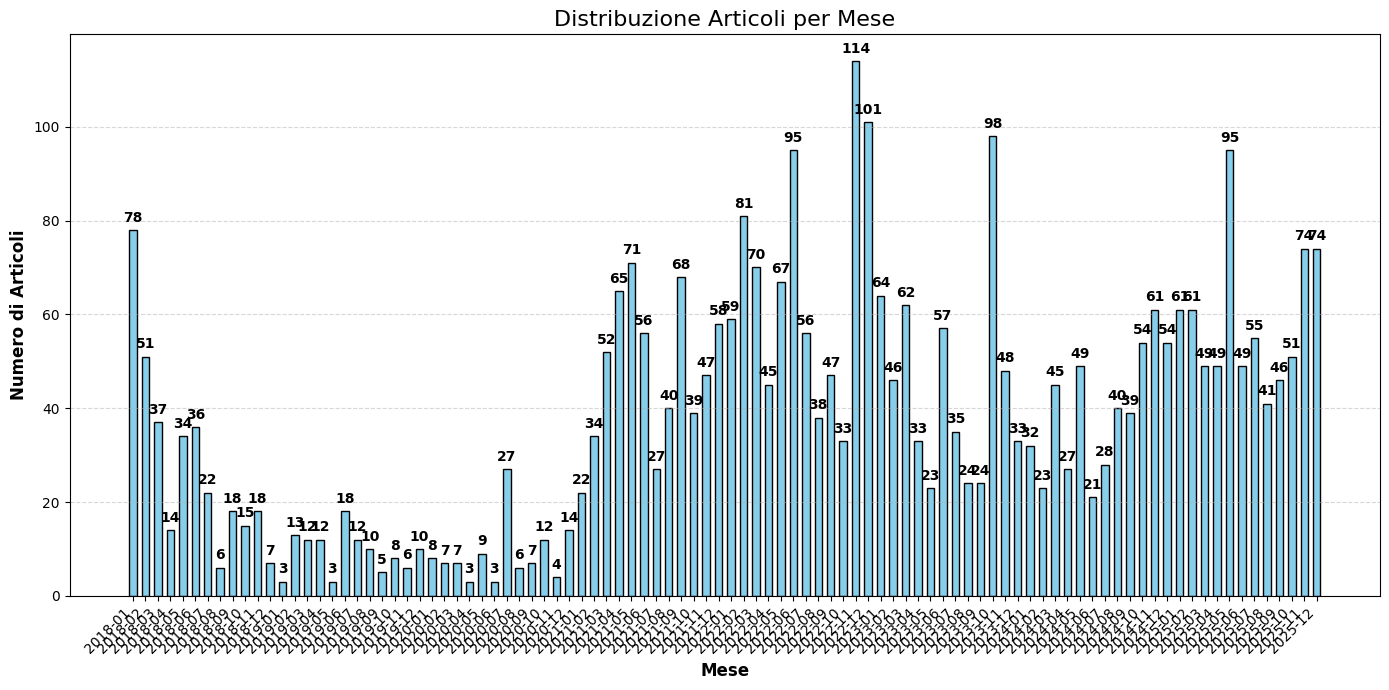

In [12]:
# 1. Connessione
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

# 2. Recupero Dati (SEMPLIFICATO)
# Non serve più l'aggregazione complessa. 
# Chiediamo a Mongo solo il campo 'pub_date' di tutti i documenti.
projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato! Assicurati di aver popolato il DB con il nuovo script.")
else:
    # 3. Preparazione DataFrame
    df = pd.DataFrame(data)
    
    # Verifica che la colonna 'pub_date' esista (per sicurezza)
    if 'pub_date' not in df.columns:
        print("ERRORE: Il campo 'pub_date' non è stato trovato nei documenti.")
        print("Esempio di documento nel DB:", collection.find_one())
    else:
        # Conversione data
        df['data'] = pd.to_datetime(df['pub_date'], errors='coerce')
        
        # Rimuove eventuali date non valide (NaT)
        df = df.dropna(subset=['data'])

        # Raggruppa per mese
        df['mese_anno'] = df['data'].dt.to_period('M')
        conteggio_mensile = df['mese_anno'].value_counts().sort_index()

        # Preparazione dati per il grafico
        mesi = conteggio_mensile.index.strftime('%Y-%m') 
        conteggi = conteggio_mensile.values

        # 4. Generazione Grafico (Il tuo codice di plotting era già ottimo!)
        plt.figure(figsize=(14, 7)) 
        
        plt.bar(mesi, conteggi, color='skyblue', edgecolor='black', width=0.6)

        plt.xlabel('Mese', fontsize=12, fontweight='bold')
        plt.ylabel('Numero di Articoli', fontsize=12, fontweight='bold')
        plt.title('Distribuzione Articoli per Mese', fontsize=16)
        
        # Formattazione asse X
        plt.xticks(
            rotation=45, 
            ha='right', 
            fontsize=10 
        )
        
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        # Etichette sopra le barre
        for i, v in enumerate(conteggi):
            plt.text(i, v + (max(conteggi)*0.01), str(v), ha='center', va='bottom', fontweight='bold')

        plt.subplots_adjust(bottom=0.2)
        plt.tight_layout()
        plt.show()

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_12216\3403604660.py:42: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()


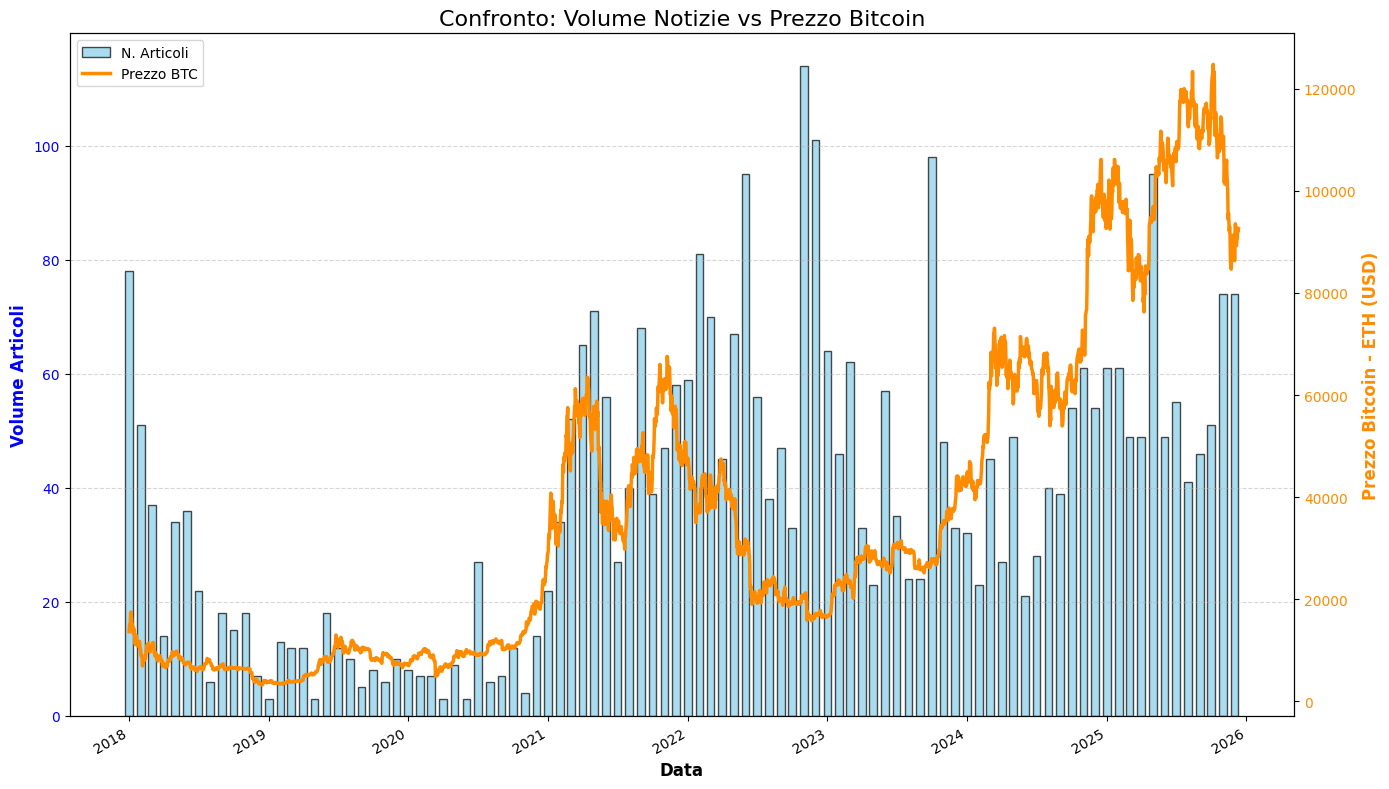

In [15]:

# --- 1. PREPARAZIONE DATI BITCOIN (df_btc) ---
# Assicura che 'df_btc' sia caricato. Se non c'è, crea un placeholder.
if 'df' not in locals():
    print("ATTENZIONE: 'df_btc' non trovato. Caricalo prima (es. con yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy() # Lavoriamo su una copia

# Assicuriamo che l'indice sia datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filtriamo dal 2021 in poi per coerenza
    df_btc_filtered = df_btc[df_btc.index >= '2018-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. RECUPERO DATI ARTICOLI (IL TUO CODICE FUNZIONANTE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato su MongoDB!")
else:
    # Creazione DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversione e Pulizia
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Filtro temporale (opzionale, per allineare al grafico BTC)
        df_articles = df_articles[df_articles['data'] >= '2018-01-01']

        # Raggruppamento per mese
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** TRUCCO IMPORTANTE ***
        # Convertiamo l'indice (Period) in Timestamp (inizio mese)
        # Questo permette a Matplotlib di sovrapporre correttamente la linea del Bitcoin
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERAZIONE GRAFICO COMBINATO ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # ASSE Y SINISTRO (BARRE - ARTICOLI)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='N. Articoli')
        
        ax1.set_xlabel('Data', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Volume Articoli', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # ASSE Y DESTRO (LINEA - PREZZO BITCOIN)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00' # Arancione Bitcoin
            color_line2 = "#00FF0D" #  Eth
            color_line3 = "#D400FF"
            
            # Gestione sicura della colonna Close
            try:
                # Prova accesso standard o MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzoeth = df_btc_filtered['Close']['ETH-USD'] if 'ETH-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzosp = df_btc_filtered['Close']['^GSPC'] if '^GSPC' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Fallback brutale alla prima colonna
            
            ax2.plot(df_btc_filtered.index, prezzo, color=color_line, linewidth=2.5, label='Prezzo BTC')


            ax2.set_ylabel('Prezzo Bitcoin - ETH (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Legenda Unificata
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Confronto: Volume Notizie vs Prezzo Bitcoin', fontsize=16)
        fig.autofmt_xdate() # Formatta date asse X
        plt.tight_layout()
        plt.show()

    else:
        print("Errore: colonna 'pub_date' non trovata nel DataFrame.")

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_12216\2178150349.py:42: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()


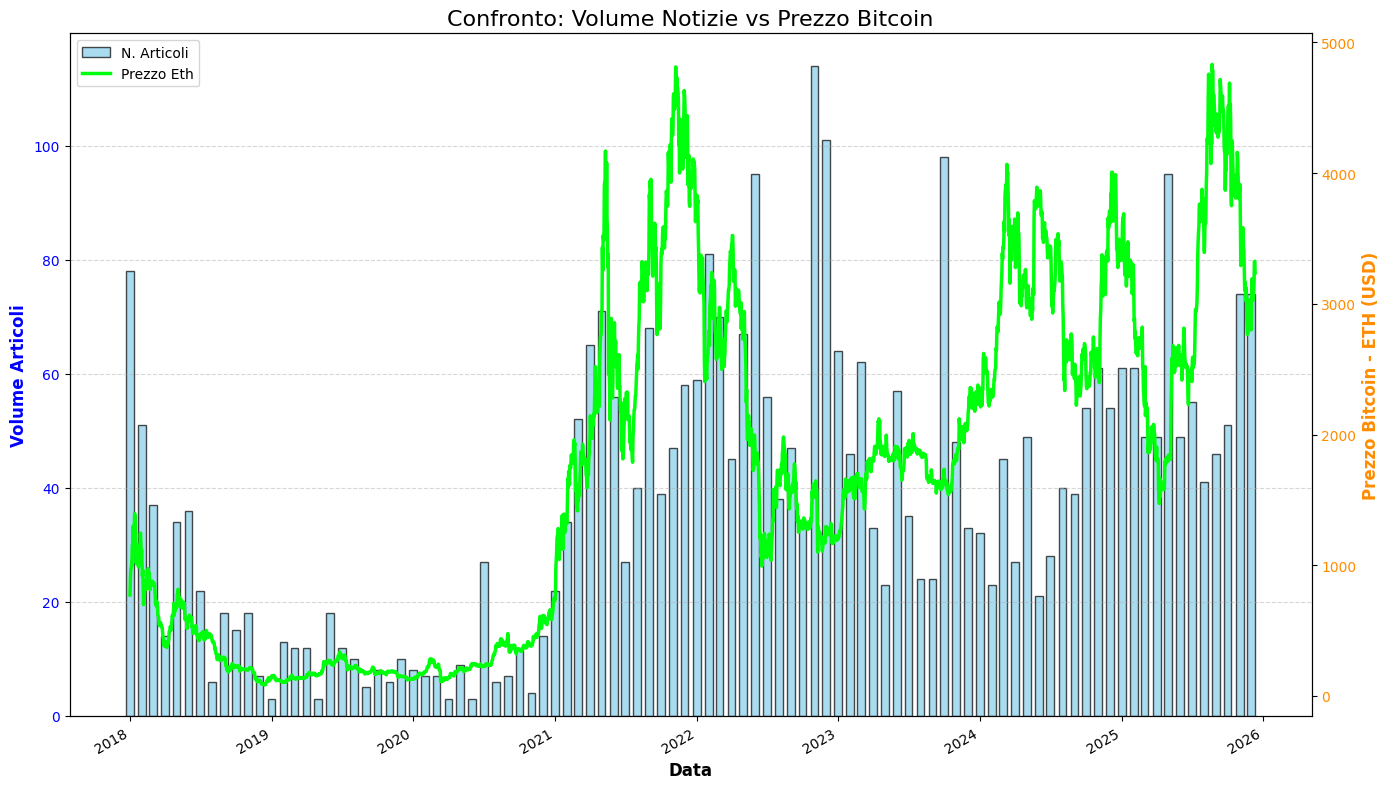

In [16]:

# --- 1. PREPARAZIONE DATI BITCOIN (df_btc) ---
# Assicura che 'df_btc' sia caricato. Se non c'è, crea un placeholder.
if 'df' not in locals():
    print("ATTENZIONE: 'df_btc' non trovato. Caricalo prima (es. con yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy() # Lavoriamo su una copia

# Assicuriamo che l'indice sia datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filtriamo dal 2021 in poi per coerenza
    df_btc_filtered = df_btc[df_btc.index >= '2018-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. RECUPERO DATI ARTICOLI (IL TUO CODICE FUNZIONANTE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato su MongoDB!")
else:
    # Creazione DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversione e Pulizia
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Filtro temporale (opzionale, per allineare al grafico BTC)
        df_articles = df_articles[df_articles['data'] >= '2018-01-01']

        # Raggruppamento per mese
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** TRUCCO IMPORTANTE ***
        # Convertiamo l'indice (Period) in Timestamp (inizio mese)
        # Questo permette a Matplotlib di sovrapporre correttamente la linea del Bitcoin
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERAZIONE GRAFICO COMBINATO ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # ASSE Y SINISTRO (BARRE - ARTICOLI)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='N. Articoli')
        
        ax1.set_xlabel('Data', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Volume Articoli', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # ASSE Y DESTRO (LINEA - PREZZO BITCOIN)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00' # Arancione Bitcoin
            color_line2 = "#00FF0D" #  Eth
            color_line3 = "#D400FF"
            
            # Gestione sicura della colonna Close
            try:
                # Prova accesso standard o MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzoeth = df_btc_filtered['Close']['ETH-USD'] if 'ETH-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzosp = df_btc_filtered['Close']['^GSPC'] if '^GSPC' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Fallback brutale alla prima colonna
            
            ax2.plot(df_btc_filtered.index, prezzoeth, color=color_line2, linewidth=2.5, label='Prezzo Eth')

            ax2.set_ylabel('Prezzo Bitcoin - ETH (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Legenda Unificata
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Confronto: Volume Notizie vs Prezzo Bitcoin', fontsize=16)
        fig.autofmt_xdate() # Formatta date asse X
        plt.tight_layout()
        plt.show()

    else:
        print("Errore: colonna 'pub_date' non trovata nel DataFrame.")

client.close()